##  Importing necessary packages

In [1]:
import urllib.request
from bs4 import BeautifulSoup
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from geopy.geocoders import Nominatim
import folium
import requests
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

##  Scraping the Wikipedia page

### Using urllib and beautifulsoup to obtain the data  
_(You can skip these steps and directly load the data.The code is given below under "Load data directly"_

In [ ]:
url = "https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Mumbai"
req = urllib.request.urlopen(url)
article = req.read().decode()

In [ ]:
soup = BeautifulSoup(article, 'html.parser')
table = soup.find('table', class_='sortable')

Now we parse the table into a Pandas dataframe

In [ ]:
#headings
ths = table.find_all('th')
headings = [th.text.strip() for th in ths]

#create dataframe
neighbourhoods = pd.DataFrame(columns=headings)
neighbourhoods

In [ ]:
# scrape rows into dataframe
for tr in table.find_all('tr'):
    tds = tr.find_all('td')
    if not tds:
        continue                            #skips first row with headings
    a, l, lat, long = [td.text.strip() for td in tds]
    neighbourhoods = neighbourhoods.append({'Area': a, 'Location': l, 'Latitude': lat, 'Longitude': long}, ignore_index=True)

neighbourhoods.head()

In [ ]:
neighbourhoods.to_excel('Mumbai locations.xlsx')

#### *Load data directly*

In [2]:
ml=pd.read_excel('Mumbai locations.xlsx')
ml.head()

,Area,Location,Suburbs,Latitude,Longitude
0,Amboli,Andheri,Western Suburbs,19.129300,72.843400
1,"Chakala, Andheri",Western Suburbs,Western Suburbs,19.111388,72.860833
2,D.N. Nagar,Andheri,Western Suburbs,19.124085,72.831373
3,Four Bungalows,Andheri,Western Suburbs,19.124714,72.827210
4,Lokhandwala,Andheri,Western Suburbs,19.130815,72.829270


##  Creating maps

In [3]:
address = 'Mumbai'

geolocator = Nominatim(user_agent="my_application")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Mumbai are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Mumbai are 18.9387711, 72.8353355.


In [4]:
# create map of Mumbai using latitude and longitude values
map_mumbai = folium.Map(location=[latitude+0.099,longitude], zoom_start=11)
map_mumbai

In [5]:
ml['Suburbs'].unique()

array(['Western Suburbs', 'Eastern Suburbs', 'Harbour Suburbs',
       'South Mumbai', 'Mumbai'], dtype=object)

In [8]:
colours =['blue','green','red','yellow','gray']
for a, l, sub, lat, long in zip(ml['Area'], ml['Location'], ml['Suburbs'],ml['Latitude'], ml['Longitude']):
    if sub=='Western Suburbs':
        label = '{}: {}, {}'.format(a, sub, l)
        label = folium.Popup(label)
        folium.CircleMarker(
            [lat, long],
            radius=4,
            popup=label,
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.7).add_to(map_mumbai)
    elif sub=='Eastern Suburbs':
        label = '{}: {}, {}'.format(a, sub, l)
        label = folium.Popup(label)
        folium.CircleMarker(
            [lat, long],
            radius=4,
            popup=label,
            color='green',
            fill=True,
            fill_color='green',
            fill_opacity=0.7).add_to(map_mumbai)
    elif sub=='Harbour Suburbs':
        label = '{}: {}, {}'.format(a, sub, l)
        label = folium.Popup(label)
        folium.CircleMarker(
            [lat, long],
            radius=4,
            popup=label,
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=0.7).add_to(map_mumbai)
    elif sub=='South Mumbai':
        label = '{}: {}, {}'.format(a, sub, l)
        label = folium.Popup(label)
        folium.CircleMarker(
            [lat, long],
            radius=4,
            popup=label,
            color='yellow',
            fill=True,
            fill_color='yellow',
            fill_opacity=0.7).add_to(map_mumbai)
    elif sub=='Mumbai':
        label = '{}: {}, {}'.format(a, sub, l)
        label = folium.Popup(label)
        folium.CircleMarker(
            [lat, long],
            radius=4,
            popup=label,
            color='gray',
            fill=True,
            fill_color='gray',
            fill_opacity=0.7).add_to(map_mumbai)
map_mumbai

##  Getting foursquare data  
_(You can skip these steps and directly load the data.The code is given below under "Load data directly"_

In [ ]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Code for getting nearby venues:

In [ ]:
def getNearbyVenues(area, location, suburbs, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for a, l, sub, lat, lng in zip(area, location, suburbs, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            a,
            l,
            sub,
            lat, 
       c     lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])


    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Area','Location',
                  'Suburbs', 
                  'Area Latitude', 
                  'Area Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [ ]:
mumbai_venues = getNearbyVenues(area=df['Area'], location=df['Location'], suburbs=df['Suburbs'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )
mumbai_venues.head()

In [ ]:
mumbai_venues.to_excel('Mumbai Venues.xlsx')

#### *Load data directly*

In [9]:
mv=pd.read_excel('Mumbai Venues.xlsx')

In [10]:
mv.drop(['Unnamed: 0'],axis=1,inplace=True)
mv.head()

,Area,Location,Suburbs,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Amboli,Andheri,Western Suburbs,19.1293,72.8434,Cafe Arfa,19.128930,72.847140,Indian Restaurant
1,Amboli,Andheri,Western Suburbs,19.1293,72.8434,"5 Spice , Bandra",19.130421,72.847206,Chinese Restaurant
2,Amboli,Andheri,Western Suburbs,19.1293,72.8434,Subway,19.127860,72.844461,Sandwich Place
3,Amboli,Andheri,Western Suburbs,19.1293,72.8434,Cafe Coffee Day,19.127748,72.844663,Coffee Shop
4,Amboli,Andheri,Western Suburbs,19.1293,72.8434,Spices & Chillies,19.127765,72.844131,Asian Restaurant


In [11]:
sub_venues=mv['Suburbs'].value_counts()
sub_venues=pd.DataFrame(sub_venues)
sub_venues

,Suburbs
South Mumbai,620
Western Suburbs,535
Eastern Suburbs,155
Harbour Suburbs,29
Mumbai,9


<AxesSubplot:>

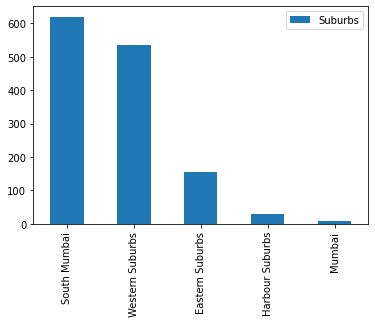

In [12]:
sub_venues.plot.bar()

We now analyze each neighbourhood

In [13]:
# one hot encoding
mumbai_onehot = pd.get_dummies(mv[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
mumbai_onehot['Area'] = mv['Area']

# move neighborhood column to the first column
fixed_columns = [mumbai_onehot.columns[-1]] + list(mumbai_onehot.columns[:-1])
mumbai_onehot = mumbai_onehot[fixed_columns]

mumbai_onehot.head()

,Area,ATM,Afghan Restaurant,American Restaurant,Amphitheater,Antique Shop,Aquarium,Arcade,Art Gallery,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bar,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Bengali Restaurant,Big Box Store,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Buffet,Burger Joint,Bus Station,Café,Campground,Cantonese Restaurant,Chaat Place,Cheese Shop,Chinese Restaurant,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Auditorium,Comedy Club,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cricket Ground,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dhaba,Dim Sum Restaurant,Diner,Donut Shop,Electronics Store,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Garden,Garden Center,Gastropub,General Entertainment,German Restaurant,Gift Shop,Goan Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,History Museum,Hobby Shop,Hookah Bar,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Lighthouse,Liquor Store,Lounge,Maharashtrian Restaurant,Market,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Monument / Landmark,Movie Theater,Moving Target,Mughlai Restaurant,Multiplex,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Other Great Outdoors,Outlet Mall,Paper / Office Supplies Store,Park,Parsi Restaurant,Performing Arts Venue,Pharmacy,Pizza Place,Platform,Playground,Plaza,Pool,Pub,Recreation Center,Residential Building (Apartment / Condo),Resort,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shipping Store,Shopping Mall,Smoke Shop,Snack Place,Soccer Stadium,South Indian Restaurant,Spa,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Supermarket,Tea Room,Tennis Stadium,Tex-Mex Restaurant,Theater,Tourist Information Center,Train Station,Vegetarian / Vegan Restaurant,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Amboli,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Amboli,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Amboli,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Amboli,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Amboli,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

We can now group the venues by Postcode

In [14]:
mumbai_grouped = mumbai_onehot.groupby('Area').mean().reset_index()

In [15]:
mumbai_grouped.head()

,Area,ATM,Afghan Restaurant,American Restaurant,Amphitheater,Antique Shop,Aquarium,Arcade,Art Gallery,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bar,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Bengali Restaurant,Big Box Store,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Buffet,Burger Joint,Bus Station,Café,Campground,Cantonese Restaurant,Chaat Place,Cheese Shop,Chinese Restaurant,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Auditorium,Comedy Club,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cricket Ground,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dhaba,Dim Sum Restaurant,Diner,Donut Shop,Electronics Store,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Garden,Garden Center,Gastropub,General Entertainment,German Restaurant,Gift Shop,Goan Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,History Museum,Hobby Shop,Hookah Bar,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Lighthouse,Liquor Store,Lounge,Maharashtrian Restaurant,Market,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Monument / Landmark,Movie Theater,Moving Target,Mughlai Restaurant,Multiplex,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Other Great Outdoors,Outlet Mall,Paper / Office Supplies Store,Park,Parsi Restaurant,Performing Arts Venue,Pharmacy,Pizza Place,Platform,Playground,Plaza,Pool,Pub,Recreation Center,Residential Building (Apartment / Condo),Resort,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shipping Store,Shopping Mall,Smoke Shop,Snack Place,Soccer Stadium,South Indian Restaurant,Spa,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Supermarket,Tea Room,Tennis Stadium,Tex-Mex Restaurant,Theater,Tourist Information Center,Train Station,Vegetarian / Vegan Restaurant,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Agripada,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.00,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.200000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.200000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.200000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Altamount Road,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00,0.250000,0.00,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.125000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.125000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.125000,0.0,0.0,0.0,0.0,0.0,

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [16]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [17]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Area']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
area_venues_sorted = pd.DataFrame(columns=columns)
area_venues_sorted['Area'] = mumbai_grouped['Area']

for ind in np.arange(mumbai_grouped.shape[0]):
    area_venues_sorted.iloc[ind, 1:] = return_most_common_venues(mumbai_grouped.iloc[ind, :], num_top_venues)

area_venues_sorted.head()

,Area,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agripada,Gym,Bakery,Coffee Shop,Restaurant,Indian Restaurant,Cosmetics Shop,Dim Sum Restaurant,Comedy Club,Event Space,Electronics Store
1,Altamount Road,Café,Sandwich Place,Indian Restaurant,Coffee Shop,Theater,Pizza Place,Bakery,Electronics Store,Donut Shop,Diner
2,Amboli,Gym,Asian Restaurant,Chinese Restaurant,Sandwich Place,Coffee Shop,Indian Restaurant,Fast Food Restaurant,Gastropub,Dance Studio,Donut Shop
3,Amrut Nagar,Indian Restaurant,Café,Asian Restaurant,Fast Food Restaurant,Restaurant,Electronics Store,Shopping Mall,Italian Restaurant,Sandwich Place,Bookstore
4,Asalfa,Bus Station,Men's Store,Hostel,Campground,Department Store,Event Space,Electronics Store,Donut Shop,Diner,Dim Sum Restaurant


## Cluster areas

In [18]:
# set number of clusters
kclusters = 5

mumbai_grouped_clustering = mumbai_grouped.drop('Area', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(mumbai_grouped_clustering)

In [19]:
mumbai_grouped_clustering.head()

,ATM,Afghan Restaurant,American Restaurant,Amphitheater,Antique Shop,Aquarium,Arcade,Art Gallery,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bar,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Bengali Restaurant,Big Box Store,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Buffet,Burger Joint,Bus Station,Café,Campground,Cantonese Restaurant,Chaat Place,Cheese Shop,Chinese Restaurant,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Auditorium,Comedy Club,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cricket Ground,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dhaba,Dim Sum Restaurant,Diner,Donut Shop,Electronics Store,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Garden,Garden Center,Gastropub,General Entertainment,German Restaurant,Gift Shop,Goan Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,History Museum,Hobby Shop,Hookah Bar,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Lighthouse,Liquor Store,Lounge,Maharashtrian Restaurant,Market,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Monument / Landmark,Movie Theater,Moving Target,Mughlai Restaurant,Multiplex,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Other Great Outdoors,Outlet Mall,Paper / Office Supplies Store,Park,Parsi Restaurant,Performing Arts Venue,Pharmacy,Pizza Place,Platform,Playground,Plaza,Pool,Pub,Recreation Center,Residential Building (Apartment / Condo),Resort,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shipping Store,Shopping Mall,Smoke Shop,Snack Place,Soccer Stadium,South Indian Restaurant,Spa,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Supermarket,Tea Room,Tennis Stadium,Tex-Mex Restaurant,Theater,Tourist Information Center,Train Station,Vegetarian / Vegan Restaurant,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.00,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.200000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.200000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.200000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00,0.250000,0.00,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.125000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.125000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.125000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,

In [20]:
area_venues_sorted['Cluster label'] = kmeans.labels_
mumbai_merged = pd.merge(area_venues_sorted, ml, how='left',
        on='Area', validate="1:1")

In [21]:
mumbai_merged.head()

,Area,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster label,Location,Suburbs,Latitude,Longitude
0,Agripada,Gym,Bakery,Coffee Shop,Restaurant,Indian Restaurant,Cosmetics Shop,Dim Sum Restaurant,Comedy Club,Event Space,Electronics Store,0,South Mumbai,South Mumbai,18.977700,72.827300
1,Altamount Road,Café,Sandwich Place,Indian Restaurant,Coffee Shop,Theater,Pizza Place,Bakery,Electronics Store,Donut Shop,Diner,1,South Mumbai,South Mumbai,18.968100,72.809500
2,Amboli,Gym,Asian Restaurant,Chinese Restaurant,Sandwich Place,Coffee Shop,Indian Restaurant,Fast Food Restaurant,Gastropub,Dance Studio,Donut Shop,1,Andheri,Western Suburbs,19.129300,72.843400
3,Amrut Nagar,Indian Restaurant,Café,Asian Restaurant,Fast Food Restaurant,Restaurant,Electronics Store,Shopping Mall,Italian Restaurant,Sandwich Place,Bookstore,1,Ghatkopar,Eastern Suburbs,19.102077,72.912835
4,Asalfa,Bus Station,Men's Store,Hostel,Campground,Department Store,Event Space,Electronics Store,Donut Shop,Diner,Dim Sum Restaurant,3,Ghatkopar,Eastern Suburbs,19.091000,72.901000


##  Clusters on map

In [22]:
# create map
map_clusters = folium.Map(location=[latitude+0.099, longitude], zoom_start=11)#tiles='Mapbox Bright'

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

colours =['blue','green','red','black','yellow']

# add markers to the map
markers_colors = []
for lat, lon, l, a, cluster in zip(mumbai_merged['Latitude'], mumbai_merged['Longitude'], mumbai_merged['Location'], mumbai_merged['Area'], mumbai_merged['Cluster label']):
    label = folium.Popup(str(l) + '(' + str(a) + '): Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=colours[cluster-1],
        fill=True,
        fill_color=colours[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Cluster Analysis

### *Cluster 1*

In [23]:
cluster1=mumbai_merged.loc[mumbai_merged['Cluster label'] == 0, mumbai_merged.columns[[0] + list(range(1, mumbai_merged.shape[1]))]]
cluster1.shape

(33, 16)

In [24]:
area1=cluster1['Area']
mv1= mv[mv['Area'].isin(area1)]
mv1.head()

,Area,Location,Suburbs,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
66,Marol,Andheri,Western Suburbs,19.119219,72.882743,Benzys,19.120165,72.880100,Indian Restaurant
67,Marol,Andheri,Western Suburbs,19.119219,72.882743,Uttam Da Dhaba,19.116073,72.879827,Indian Restaurant
68,Marol,Andheri,Western Suburbs,19.119219,72.882743,Baskin-Robbins,19.121536,72.878745,Ice Cream Shop
69,Marol,Andheri,Western Suburbs,19.119219,72.882743,Wazwaan Restaurant,19.120388,72.885288,Diner
70,Marol,Andheri,Western Suburbs,19.119219,72.882743,Shubham Greens,19.117132,72.882636,Indian Restaurant


In [25]:
w1=mv1['Venue Category'].value_counts()
w1=pd.DataFrame(w1)
w1
pie1 = w1.drop(w1[w1['Venue Category'] < 5].index)
pie1

,Venue Category
Indian Restaurant,112
Café,27
Fast Food Restaurant,21
Bar,20
Coffee Shop,20
Ice Cream Shop,13
Bakery,12
Chinese Restaurant,12
Hotel,12
Pizza Place,11


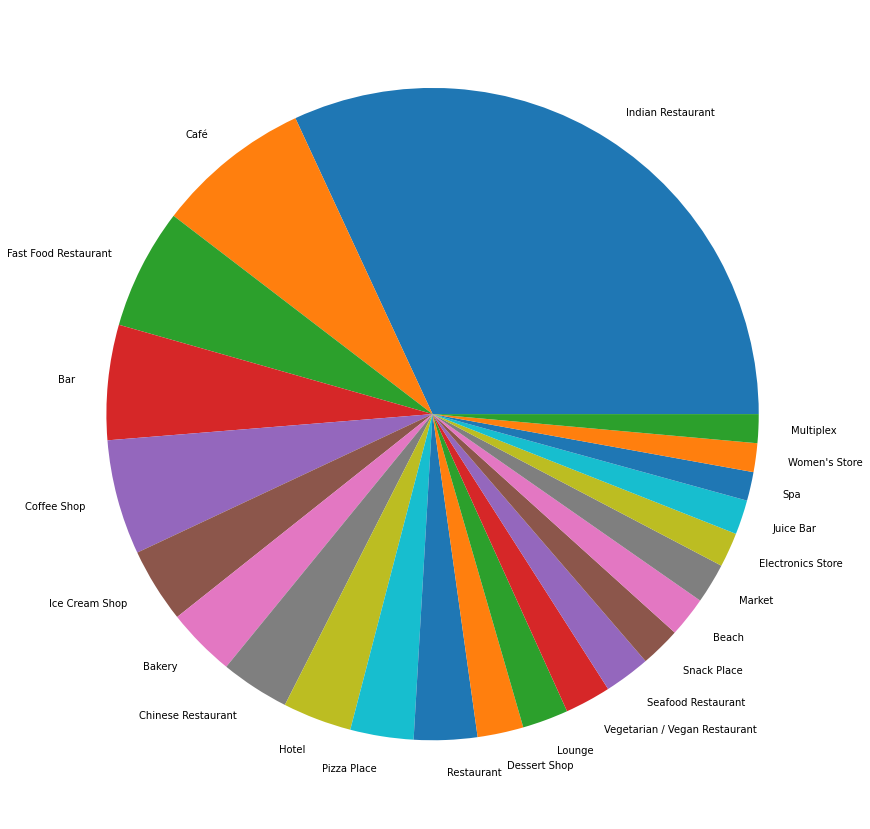

In [26]:
fig = plt.figure(figsize =(15, 15)) 
plt.pie(pie1['Venue Category'], labels =list(pie1.index) ) 
plt.show() 

### *Cluster 2*

In [27]:
cluster2=mumbai_merged.loc[mumbai_merged['Cluster label'] == 1, mumbai_merged.columns[[0] + list(range(1, mumbai_merged.shape[1]))]]
cluster2.shape

(40, 16)

In [28]:
area2=cluster2['Area']
mv2= mv[mv['Area'].isin(area2)]
mv2.head()

,Area,Location,Suburbs,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Amboli,Andheri,Western Suburbs,19.1293,72.8434,Cafe Arfa,19.128930,72.847140,Indian Restaurant
1,Amboli,Andheri,Western Suburbs,19.1293,72.8434,"5 Spice , Bandra",19.130421,72.847206,Chinese Restaurant
2,Amboli,Andheri,Western Suburbs,19.1293,72.8434,Subway,19.127860,72.844461,Sandwich Place
3,Amboli,Andheri,Western Suburbs,19.1293,72.8434,Cafe Coffee Day,19.127748,72.844663,Coffee Shop
4,Amboli,Andheri,Western Suburbs,19.1293,72.8434,Spices & Chillies,19.127765,72.844131,Asian Restaurant


In [29]:
mv2['Venue Category'].value_counts()

Indian Restaurant                           59
Café                                        53
Bakery                                      38
Fast Food Restaurant                        30
Coffee Shop                                 29
Ice Cream Shop                              28
Chinese Restaurant                          27
Pizza Place                                 26
Restaurant                                  24
Italian Restaurant                          21
Bar                                         19
Dessert Shop                                19
Snack Place                                 17
Sandwich Place                              17
Hotel                                       13
Asian Restaurant                            12
Department Store                            12
Seafood Restaurant                          11
Electronics Store                           11
Lounge                                      10
Theater                                      9
Pub          

In [30]:
w2=mv2['Venue Category'].value_counts()
w2=pd.DataFrame(w2)
w2
pie2 = w2.drop(w2[w2['Venue Category'] < 5].index)
pie2

,Venue Category
Indian Restaurant,59
Café,53
Bakery,38
Fast Food Restaurant,30
Coffee Shop,29
Ice Cream Shop,28
Chinese Restaurant,27
Pizza Place,26
Restaurant,24
Italian Restaurant,21


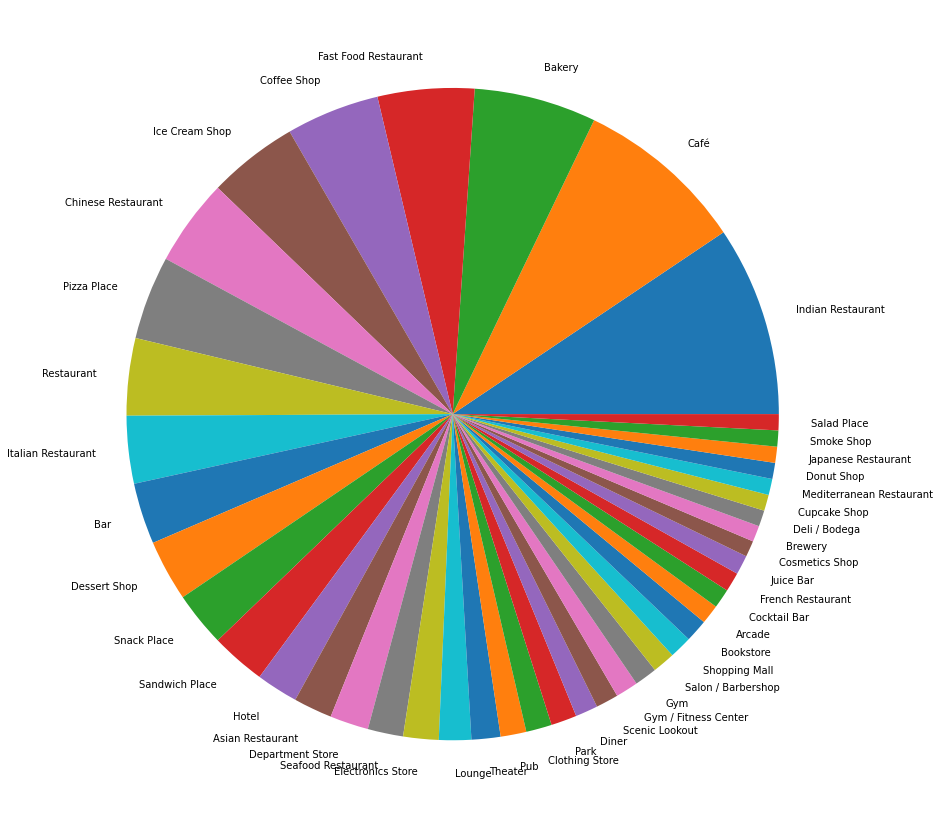

In [31]:
fig = plt.figure(figsize =(15, 15)) 
plt.pie(pie2['Venue Category'], labels =list(pie2.index) ) 
  
plt.show() 

### *Cluster 3*

In [32]:
cluster3=mumbai_merged.loc[mumbai_merged['Cluster label'] == 2, mumbai_merged.columns[[0] + list(range(1, mumbai_merged.shape[1]))]]

In [33]:
area3=cluster3['Area']
mv3= mv[mv['Area'].isin(area3)]
mv3.head()

,Area,Location,Suburbs,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
265,Bangur Nagar,Goregaon,Western Suburbs,19.167362,72.832252,Katta aka Narayan,19.163502,72.83159,Smoke Shop


In [34]:
mv3['Venue Category'].value_counts()

Smoke Shop    1
Name: Venue Category, dtype: int64

### *Cluster 4*

In [35]:
cluster4=mumbai_merged.loc[mumbai_merged['Cluster label'] == 3, mumbai_merged.columns[[0] + list(range(1, mumbai_merged.shape[1]))]]

In [36]:
area4=cluster4['Area']
mv4= mv[mv['Area'].isin(area4)]
mv4.head()

,Area,Location,Suburbs,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
118,Versova,Andheri,Western Suburbs,19.120000,72.820000,Renaissance Federation Club,19.123644,72.821912,Bar
119,Versova,Andheri,Western Suburbs,19.120000,72.820000,K. D. Road Ground,19.121697,72.823700,Soccer Stadium
478,Naigaon,Vasai,Western Suburbs,19.351467,72.846343,Naigaon Railway Station,19.351214,72.846329,Train Station
479,Naigaon,Vasai,Western Suburbs,19.351467,72.846343,naigaon railway station,19.351264,72.846214,Platform
480,Nalasopara,Vasai,Western Suburbs,19.415400,72.861300,Waliv Naka,19.416579,72.861926,Bus Station


In [37]:
mv4['Venue Category'].value_counts()

ATM                   4
Train Station         3
Bar                   2
Convenience Store     2
Bus Station           2
Harbor / Marina       2
Plaza                 1
Garden                1
Soccer Stadium        1
Hookah Bar            1
Sports Bar            1
Seafood Restaurant    1
Bakery                1
Whisky Bar            1
Hotel                 1
Platform              1
Hostel                1
Coffee Shop           1
Campground            1
Multiplex             1
Men's Store           1
Name: Venue Category, dtype: int64

In [38]:
w4=mv4['Venue Category'].value_counts()
w4=pd.DataFrame(w4)
w4

,Venue Category
ATM,4
Train Station,3
Bar,2
Convenience Store,2
Bus Station,2
Harbor / Marina,2
Plaza,1
Garden,1
Soccer Stadium,1
Hookah Bar,1


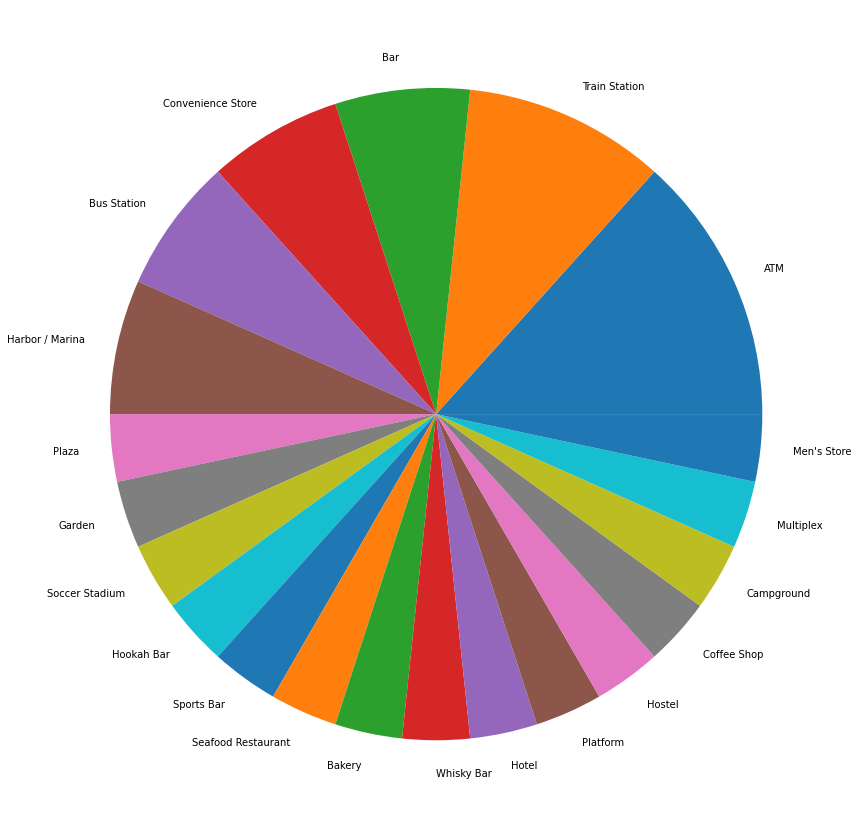

In [39]:
fig = plt.figure(figsize =(15, 15)) 
plt.pie(w4['Venue Category'], labels =list(w4.index) ) 
  
# show plot 
plt.show()

### *Cluster 5*

In [40]:
cluster5=mumbai_merged.loc[mumbai_merged['Cluster label'] == 4, mumbai_merged.columns[[0] + list(range(1, mumbai_merged.shape[1]))]]

In [41]:
area5=cluster5['Area']
mv5= mv[mv['Area'].isin(area5)]
mv5.head()

,Area,Location,Suburbs,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
122,Bhayandar,Mira-Bhayandar,Western Suburbs,19.29,72.85,D Mart,19.293391,72.849255,Shipping Store


In [42]:
mv5['Venue Category'].value_counts()

Shipping Store    1
Name: Venue Category, dtype: int64

## Analysisng Suburbs

In [43]:
harbour_sub=mumbai_merged.loc[mumbai_merged['Suburbs'] == 'Harbour Suburbs']
harbour_sub.head()

,Area,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster label,Location,Suburbs,Latitude,Longitude
18,Chembur,Indian Restaurant,Fast Food Restaurant,Music Store,Smoke Shop,Bar,Pool,Pizza Place,Coffee Shop,General Entertainment,Gastropub,0,Harbour Suburbs,Harbour Suburbs,19.051,72.894
30,Deonar,Fast Food Restaurant,Indian Restaurant,Pool,Diner,Electronics Store,Smoke Shop,Bar,Coffee Shop,General Entertainment,Gastropub,1,Govandi,Harbour Suburbs,19.050,72.890
56,Mankhurd,ATM,Train Station,Sports Bar,Coffee Shop,Gift Shop,Falafel Restaurant,Electronics Store,Donut Shop,Diner,Dim Sum Restaurant,3,Harbour Suburbs,Harbour Suburbs,19.050,72.930


In [45]:
western_sub=mumbai_merged.loc[mumbai_merged['Suburbs'] == 'Western Suburbs']
western_sub.head()

,Area,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster label,Location,Suburbs,Latitude,Longitude
2,Amboli,Gym,Asian Restaurant,Chinese Restaurant,Sandwich Place,Coffee Shop,Indian Restaurant,Fast Food Restaurant,Gastropub,Dance Studio,Donut Shop,1,Andheri,Western Suburbs,19.129300,72.843400
6,Bandstand Promenade,Scenic Lookout,Gym,Beach,Hotel Bar,Food Truck,Indian Restaurant,Italian Restaurant,Fast Food Restaurant,Lounge,Chinese Restaurant,1,Bandra,Western Suburbs,19.042718,72.819132
7,Bangur Nagar,Smoke Shop,Cocktail Bar,Falafel Restaurant,Event Space,Electronics Store,Donut Shop,Diner,Dim Sum Restaurant,Dhaba,Dessert Shop,2,Goregaon,Western Suburbs,19.167362,72.832252
9,Bhayandar,Shipping Store,Yoga Studio,Cocktail Bar,Event Space,Electronics Store,Donut Shop,Diner,Dim Sum Restaurant,Dhaba,Dessert Shop,4,Mira-Bhayandar,Western Suburbs,19.290000,72.850000
15,"Chakala, Andheri",Hotel,Multiplex,Café,Restaurant,Fast Food Restaurant,Falafel Restaurant,Asian Restaurant,Pizza Place,Seafood Restaurant,Indian Restaurant,1,Western Suburbs,Western Suburbs,19.111388,72.860833


In [46]:
eastern_sub=mumbai_merged.loc[mumbai_merged['Suburbs'] == 'Eastern Suburbs']
eastern_sub.head()

,Area,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster label,Location,Suburbs,Latitude,Longitude
3,Amrut Nagar,Indian Restaurant,Café,Asian Restaurant,Fast Food Restaurant,Restaurant,Electronics Store,Shopping Mall,Italian Restaurant,Sandwich Place,Bookstore,1,Ghatkopar,Eastern Suburbs,19.102077,72.912835
4,Asalfa,Bus Station,Men's Store,Hostel,Campground,Department Store,Event Space,Electronics Store,Donut Shop,Diner,Dim Sum Restaurant,3,Ghatkopar,Eastern Suburbs,19.091000,72.901000
8,Bhandup,Indian Restaurant,Café,Big Box Store,Sports Bar,Vegetarian / Vegan Restaurant,Shopping Mall,Multiplex,Arcade,Pizza Place,Fried Chicken Joint,0,Eastern Suburbs,Eastern Suburbs,19.140000,72.930000
16,Chandivali,Snack Place,Steakhouse,Hotel,Karaoke Bar,Department Store,Ice Cream Shop,Liquor Store,Gym Pool,Grocery Store,Convenience Store,1,Powai,Eastern Suburbs,19.110000,72.900000
39,Hiranandani Gardens,Indian Restaurant,Restaurant,Bar,Bakery,Coffee Shop,Chinese Restaurant,Department Store,Dessert Shop,Park,Pizza Place,1,Powai,Eastern Suburbs,19.118986,72.911767


In [47]:
mumbai_city=mumbai_merged.loc[mumbai_merged['Suburbs'] == 'South Mumbai']
mumbai_city.head()

,Area,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster label,Location,Suburbs,Latitude,Longitude
0,Agripada,Gym,Bakery,Coffee Shop,Restaurant,Indian Restaurant,Cosmetics Shop,Dim Sum Restaurant,Comedy Club,Event Space,Electronics Store,0,South Mumbai,South Mumbai,18.9777,72.8273
1,Altamount Road,Café,Sandwich Place,Indian Restaurant,Coffee Shop,Theater,Pizza Place,Bakery,Electronics Store,Donut Shop,Diner,1,South Mumbai,South Mumbai,18.9681,72.8095
5,Ballard Estate,Harbor / Marina,Convenience Store,Hotel,Yoga Studio,Department Store,Falafel Restaurant,Event Space,Electronics Store,Donut Shop,Diner,3,Fort,South Mumbai,18.9500,72.8400
10,Bhuleshwar,Indian Restaurant,Fast Food Restaurant,Cheese Shop,Restaurant,Food,Ice Cream Shop,Market,American Restaurant,Creperie,Cricket Ground,0,South Mumbai,South Mumbai,18.9500,72.8300
11,Breach Candy,Bakery,Café,Coffee Shop,Sandwich Place,Department Store,Dessert Shop,Pizza Place,Yoga Studio,Electronics Store,Salad Place,1,South Mumbai,South Mumbai,18.9670,72.8050


In [48]:
mumbai_city['Cluster label'].unique()

array([0, 1, 3])

In [49]:
eastern_sub['Cluster label'].unique()

array([1, 3, 0])

In [50]:
western_sub['Cluster label'].unique()

array([1, 2, 4, 0, 3])

In [51]:
harbour_sub['Cluster label'].unique()

array([0, 1, 3])

In [52]:
result=mumbai_city[mumbai_city['Cluster label']==3]
result[['Area','Location','Latitude','Longitude']]

,Area,Location,Latitude,Longitude
5,Ballard Estate,Fort,18.950000,72.840000
22,Cotton Green,South Mumbai,18.986209,72.844076
23,Cuffe Parade,South Mumbai,18.910000,72.810000


In [53]:
map_mumbai = folium.Map(location=[latitude+0.05,longitude], zoom_start=12)
map_mumbai

In [61]:
for a, l, lat, long in zip(result['Area'], result['Location'], result['Latitude'],result['Longitude']):
    label = '{}, {}'.format(a, l)
    label = folium.Popup(label)
    folium.Marker(location=[lat,long],popup = a, 
                  icon= folium.Icon(color='red', 
                  icon_color='white',prefix='fa',icon ='flag')).add_to(map_mumbai)
map_mumbai